In [155]:
#Say no to warnings!
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [156]:
!pip install gensim

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score, recall_score, f1_score

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import gensim.downloader as api

from pprint import pprint

from scipy.spatial.distance import cosine

import spacy

# 1. Preliminary data analysis

In [158]:
df=pd.read_csv('https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv')

df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [159]:
print(df['label'].value_counts())

print(f'\nNumber of email: {df.shape[0]}')

label
ham     3672
spam    1499
Name: count, dtype: int64

Number of email: 5171


The dataset contains 5171 emails classified into two categories ham and spam.

The dataset is unbalanced with about 29% of the observations belonging to the spam class.

In [160]:
df.isna().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


The dataset has no null values.

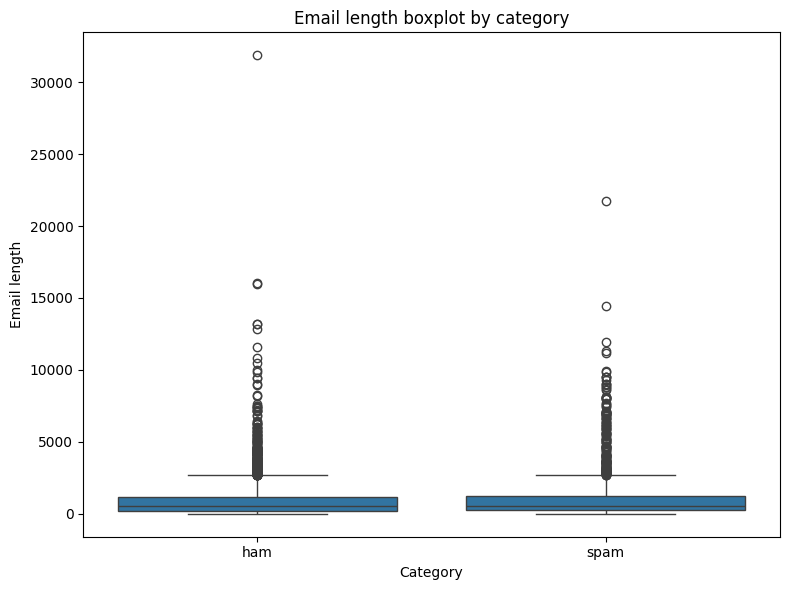

In [161]:
#Evaluate email length
df['length'] = df['text'].apply(len)

#Boxplot graph
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='length', data=df)
plt.xlabel('Category')
plt.ylabel('Email length')
plt.title('Email length boxplot by category')
plt.tight_layout()
plt.show()

From the graph obtained, no particular differences can be seen in relation to the length of the emails for the two categories.

# 2. Preprocessing

In order to make the data compatible with the model, it is necessary to carry out a pre-processing of the data. Preprocessing involves the following steps:

- Stopwords removal
- Split the dataset into train and test set
- Text vectorization
- Balancing the training set using SMOTE

**2.1 Stopwords**

Let's remove the stopwords from the dataset. Stopwords do not bring any added value for the text classification task.

In [162]:
#download stopwords
nltk.download('stopwords')

#set english as stopword language
stop_words = stopwords.words('english')
stop_words.extend(['subject', 're', 'http', 'com', 'www', 'font', 'color', 'align', 'div',
                   'https','url','xls'])


def clean_text(text):
    """
    Remove stopwords from a corpus

    args:
        text (str): corpus

    returns:
        text (str): corpus without stopwords
    """
    #convert in lower case
    text = text.lower()
    #remove punctuation
    text = re.sub(f"[{string.punctuation}]","", text)
    #remove number
    text = re.sub("\\d+", "", text)
    #remove stopwords
    text= " ".join([word for word in text.split() if word not in stop_words])
    return text

df['text_cleaned']=df['text'].apply(clean_text)
df['text_cleaned'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text_cleaned
0,enron methanol meter follow note gave monday p...
1,hpl nom january see attached file hplnol hplnol
2,neon retreat ho ho ho around wonderful time ye...
3,photoshop windows office cheap main trending a...
4,indian springs deal book teco pvr revenue unde...


**2.2 Train and test dataset**

In [163]:
#email dataset
X=df['text_cleaned']
#label dataset (0:ham , 1:spam)
y=df['label_num']

#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print(f'Train dataset email number: {X_train.shape[0]}\n')
print(y_train.value_counts())

print(f'\n\nTest dataset email number: {X_test.shape[0]}\n')
print(y_test.value_counts())

Train dataset email number: 3619

label_num
0    2570
1    1049
Name: count, dtype: int64


Test dataset email number: 1552

label_num
0    1102
1     450
Name: count, dtype: int64


**2.3 Text vectorization**

In [164]:
#Vettorizza il testo usando TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [165]:
X_test_vectorized.shape

(1552, 37076)

**2.4 Balancing train set**

In [166]:
# Inizializza e applica SMOTE solo al training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

In [167]:
df_train_compare=pd.concat([y_train.value_counts(), y_train_resampled.value_counts()], axis=1)
df_train_compare.columns=['Original', 'Resampled']

print(df_train_compare)

           Original  Resampled
label_num                     
0              2570       2570
1              1049       2570


After applying SMOTE the dataset is balanced. The number of observations belonging to class 0 (ham) remained unchanged, while the number of observations belonging to class 1 (spam) increased.

# 3. Email classification

In [168]:
clf=MLPClassifier(hidden_layer_sizes=(100, 50),
                  max_iter=100,
                  random_state=42,
                  activation='logistic',
                  solver='adam',
                  tol=0.005,
                  verbose=True)

In [169]:
#Kfold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [170]:
# Metrics to evaluate
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)}

In [171]:
#Cross validation
scores = cross_validate(clf, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring, error_score='raise')

Iteration 1, loss = 0.69244147
Iteration 2, loss = 0.68172897
Iteration 3, loss = 0.66017526
Iteration 4, loss = 0.60828304
Iteration 5, loss = 0.50834319
Iteration 6, loss = 0.36755635
Iteration 7, loss = 0.23868835
Iteration 8, loss = 0.15503987
Iteration 9, loss = 0.10627976
Iteration 10, loss = 0.07751855
Iteration 11, loss = 0.05966273
Iteration 12, loss = 0.04777528
Iteration 13, loss = 0.03943135
Iteration 14, loss = 0.03328293
Iteration 15, loss = 0.02864715
Iteration 16, loss = 0.02515017
Iteration 17, loss = 0.02239319
Iteration 18, loss = 0.02013217
Iteration 19, loss = 0.01829551
Iteration 20, loss = 0.01677186
Iteration 21, loss = 0.01541063
Iteration 22, loss = 0.01432610
Iteration 23, loss = 0.01333195
Iteration 24, loss = 0.01247834
Iteration 25, loss = 0.01171160
Training loss did not improve more than tol=0.005000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69314942
Iteration 2, loss = 0.68155182
Iteration 3, loss = 0.66028280
Iteration 4, loss = 0.6078

In [172]:
#scores df
scores_df=pd.DataFrame(scores)

#evaluating mean
mean_by_column = scores_df.mean(numeric_only=True)
row_mean=pd.Series(mean_by_column, index=scores_df.columns, name='mean')

#evaluating std
std_by_column = scores_df.std(numeric_only=True)
row_std = pd.Series(std_by_column, index=scores_df.columns, name='std')

#concat df
scores_df=pd.concat([scores_df,row_mean.to_frame().T], ignore_index=False)
scores_df=pd.concat([scores_df,row_std.to_frame().T], ignore_index=False)

#drop time column
scores_df = scores_df.drop(columns=['fit_time', 'score_time'])

scores_df.head(n=7)

,test_accuracy,test_precision,test_recall,test_f1
0,0.994163,0.990347,0.998054,0.994186
1,0.986381,0.973485,1.000000,0.986564
2,0.985409,0.971645,1.000000,0.985618
3,0.989300,0.979048,1.000000,0.989413
4,0.986381,0.973485,1.000000,0.986564
mean,0.988327,0.977602,0.999611,0.988469
std,0.003574,0.007647,0.000870,0.003498


The model shows high performance on all metrics evaluated via cross-validation.

The low standard deviation for all metrics indicates that the model performance is consistent across different splits of the training and validation data.

Let's train the model on the entire training set and evaluate it on the test set.

In [173]:
clf.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 0.68983648
Iteration 2, loss = 0.67343264
Iteration 3, loss = 0.62175700
Iteration 4, loss = 0.50146815
Iteration 5, loss = 0.32657341
Iteration 6, loss = 0.18959837
Iteration 7, loss = 0.11608650
Iteration 8, loss = 0.07836912
Iteration 9, loss = 0.05724067
Iteration 10, loss = 0.04407039
Iteration 11, loss = 0.03542077
Iteration 12, loss = 0.02944246
Iteration 13, loss = 0.02512065
Iteration 14, loss = 0.02186237
Iteration 15, loss = 0.01930353
Iteration 16, loss = 0.01727672
Iteration 17, loss = 0.01565023
Iteration 18, loss = 0.01428738
Iteration 19, loss = 0.01310290
Iteration 20, loss = 0.01212008
Iteration 21, loss = 0.01127265
Iteration 22, loss = 0.01051983
Iteration 23, loss = 0.00989639
Training loss did not improve more than tol=0.005000 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=100,
              random_state=42, tol=0.005, verbose=True)

In [174]:
#prediction
y_pred_test=clf.predict(X_test_vectorized)

In [175]:
print(classification_report(y_test, y_pred_test, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1102
        spam       0.95      0.98      0.97       450

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552



The results obtained on the test set are not very different from those obtained through cross validation. The model has good performance, is able to generalize and does not seem to have overfitting problems.

In [176]:
def plot_confusion_matrix(y_true, y_pred, classes=None, cmap=plt.cm.Blues):
    """
    Plot confusion matrix.

    Args:
        y_true (array) : true label.
        y_pred (array): predicted label.
        classes (list, optional): list of label to be visualized.
                                   if None, it will be used numerical label.
                                   Default is None.
        cmap (matplotlib.colors.Colormap, optional): Colormap to be used for plot.
                                                    Defaults to plt.cm.Blues.
    """
    cm = confusion_matrix(y_true, y_pred)

    if classes is None:
        unique_labels = np.unique(np.concatenate((y_true, y_pred)))
        classes = [str(l) for l in unique_labels]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

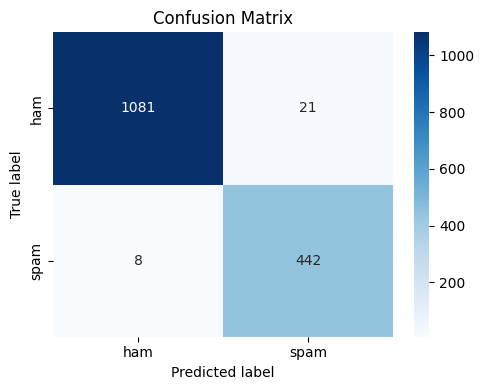

In [177]:
plot_confusion_matrix(y_test,y_pred_test, classes=['ham','spam'])

Analyzing the confusion matrix it is possible to observe that the model incorrectly classified a small number of legitimate emails as spam. This is important to minimize as it can lead to users missing important emails.

In order to minimize the false positive, let's try to increase the threshold used to classify an email as spam.

In [178]:
#predict probability
y_pred_test_proba=clf.predict_proba(X_test_vectorized)[:,1]

#set threshold
threshold=0.95

#evaluating new y_pred
y_pred_new_threshold = (y_pred_test_proba > threshold).astype(int)

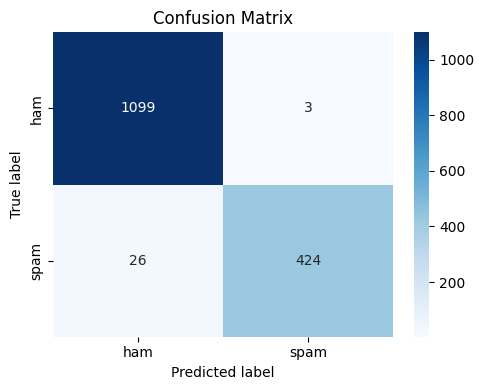

In [179]:
plot_confusion_matrix(y_test,y_pred_new_threshold, classes=['ham','spam'])

With a fairly high threshold value (0.95), the number of false positives is extremely low. Less than 0.3% of legitimate emails are classified as spam.

Increasing the threshold results in an increase in false negatives, but even with such a high threshold the model still provides high performance, managing to filter 94% of spam emails.

# 4. Topic modeling

Starting from the emails labeled as spam present in the original dataset, let's evaluate the main topics.

In [180]:
#filter spam email
df_spam=df[df['label_num']==1]

X_spam=df_spam['text_cleaned'].values

In [181]:
def sent_to_word(items):

  """
  Transform sentences into a list of word

  Args:
    items (list): list of sentences

  Returns:
    list of word
  """

  for item in items:
    yield(simple_preprocess(item, deacc=True))

def remove_stopwords(texts):

    """
    Remove stop words from a list of tokenized texts.
    Remove words that are shorter than 5 characters.

    Args:
        texts (list of list of str): A list where each element is a list of words (tokens) representing an email.

    Returns:
        list of list of str
    """

    return [[word for word in words if word not in stop_words and len (word)>=5] for words in texts]

In [182]:
#Convert email into list of word
data_words=list(sent_to_word(X_spam))
#remove stopwords
data_words=remove_stopwords(data_words)

#create dictionary
id2word=corpora.Dictionary(data_words)

#convert corpus into BoW format
corpus=[id2word.doc2bow(text) for text in data_words]

In [198]:
num_topics=5

#Find topics
lda_model=gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10, random_state=0, workers=4)

pprint(lda_model.print_topics())

#corpus topic distribution
doc_lda=lda_model[corpus]

[(0,
  '0.012*"company" + 0.010*"height" + 0.008*"width" + 0.008*"statements" + '
  '0.006*"information" + 0.005*"within" + 0.005*"report" + 0.005*"border" + '
  '0.005*"securities" + 0.004*"stock"'),
 (1,
  '0.007*"company" + 0.005*"statements" + 0.004*"information" + '
  '0.004*"investment" + 0.004*"looking" + 0.003*"email" + 0.003*"forward" + '
  '0.003*"business" + 0.003*"price" + 0.003*"stock"'),
 (2,
  '0.007*"computron" + 0.006*"please" + 0.006*"microsoft" + 0.006*"windows" + '
  '0.006*"email" + 0.005*"message" + 0.005*"contact" + 0.005*"price" + '
  '0.005*"adobe" + 0.004*"software"'),
 (3,
  '0.009*"pills" + 0.005*"viagra" + 0.005*"cialis" + 0.004*"online" + '
  '0.004*"prescription" + 0.003*"money" + 0.003*"order" + 0.003*"drugs" + '
  '0.003*"please" + 0.003*"today"'),
 (4,
  '0.004*"moopid" + 0.004*"hotlist" + 0.003*"images" + 0.003*"please" + '
  '0.002*"normally" + 0.002*"music" + 0.002*"price" + 0.002*"message" + '
  '0.002*"hottlist" + 0.002*"account"')]


The 5 main topics identified by the model are the following:

* **Topic 0 :** financial or corporate reports.

* **Topic 1 :** Similar to topic 0. Also here, reference is made to investments and finance.

* **Topic 2 :** topic related to software and technology.

* **Topic 3 :** sale of drugs related to the sexual sphere.

* **Topic 4 :** topic related to multimedia content. It could be spam promoting online accounts and potential offers.

# 5. Topic distance

Having identified the 5 main topics present within spam emails, let's evaluate the distance between them in order to understand how heterogeneous spam emails are.

In [184]:
#download embedding model
glove_model = api.load('glove-wiki-gigaword-300')

In [199]:
#set topic number
num_topics = lda_model.num_topics

#topic word and weights
topic_word_weights = [lda_model.show_topic(topicid, topn=20) for topicid in range(num_topics)]

topic_vectors_avg = []

for topic in topic_word_weights:
    #initialize topic vector
    topic_vector = np.zeros(glove_model.vector_size)
    #initialize weight sum
    weight_sum = 0
    for word, weight in topic:
        if word in glove_model.key_to_index.keys():
            topic_vector += glove_model.get_vector(word) * weight #if word in glove model: sum word vector multiplied by its weight
            weight_sum += weight
    if weight_sum > 0:
        topic_vector /= weight_sum #average topic vector
    topic_vectors_avg.append(topic_vector)

#Initialize distance topic matrix
distances_topic=np.zeros((num_topics,num_topics))
distances_topic = pd.DataFrame(distances_topic)

#evaluating topic distance
for i in range(num_topics):
  for j in range(num_topics):
    if i==j:
      distances_topic.iloc[i,j]=0
    else:
      distances_topic.iloc[i,j]=cosine(topic_vectors_avg[i], topic_vectors_avg[j])

#change column and row name
columns=[]
for i in range(num_topics):
  columns.append(f'Topic {i}')

distances_topic.columns=columns
distances_topic.index=columns

distances_topic.round(2)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Topic 0,0.00,0.11,0.40,0.53,0.34
Topic 1,0.11,0.00,0.29,0.45,0.26
Topic 2,0.40,0.29,0.00,0.46,0.18
Topic 3,0.53,0.45,0.46,0.00,0.40
Topic 4,0.34,0.26,0.18,0.40,0.00


As seen previously, topics 0 and 1 seem to be similar, both referring to finance and investment-related topics. The calculation of the distance between the two topics confirms what we have seen. The two topics appear to be very similar, with the distance between the two being close to 0.

Topic 2 and 4 have a relatively low distance of 0.18. It is logical to think of a similarity between the software/communications topic and the ones related to multimedia.

Topic 3 is the ones with the highest distances from the others. This indicates that the topic of drugs is semantically more distinct from the others.

# 6. Organization extraction

In [200]:
nlp=spacy.load('en_core_web_sm')

In [201]:
#filter legit email
df_legit=df[df['label_num']==0]

df_legit.drop(columns=['Unnamed: 0','label', 'label_num','length'], inplace=True)

In [202]:
def find_ORG(text):

  """
  Find Organization in a text

  Args:
    text (str): text

  Returns:
    list of organization
  """

  org_list=[]
  doc=nlp(text)

  for ent in doc.ents:
    if ent.label_=='ORG':
      org_list.append(ent.text)
  return org_list

In [203]:
#apply find org
df_legit['ORG']=df_legit['text_cleaned'].apply(find_ORG)

In [204]:
#filter ORG column not empty
df_legit_filt=df_legit[df_legit['ORG'].apply(len)>0]

#drop cleaned text column
df_legit_filt.drop(columns=['text_cleaned'], inplace=True)

In [205]:
df_legit_filt.head(n=10)

,text,ORG
2,"Subject: neon retreat\nho ho ho , we ' re arou...",[shop antique craft]
6,Subject: spring savings certificate - take 30 ...,"[foot locker canada, foot locker canada]"
8,Subject: noms / actual flow for 2 / 26\nwe agr...,[melissa jones]
16,Subject: re : first delivery - wheeler operati...,"[vance l taylor hou, buckley molly l carriere ..."
17,"Subject: swift - may 2001 vols\nsean ,\nfyi , ...","[enron, ect cc brian riley hou, mike morris co..."
18,Subject: meter variances - ua 4 clean - up\nda...,"[meter variances ua clean, boas]"
20,Subject: fw : ercot load comparison\n- - - - -...,"[smith doug, smith corp enron, smith corp enro..."
29,Subject: re : valero gas marketing ; meter # :...,[pat clynes corp enron enron]
30,Subject: the houston expl dec 2000\ndarren :\n...,[parker corp enron pm]
32,Subject: to : all domestic employees who parti...,"[enron corp savings, enron corp savings]"


Analyzing the first occurrences obtained by the model, some of the results are probably/certainly names of organizations. Foot locker is a well-known sportswear chain while shop antique craft could refer to an antique shop.

The model struggles to distinguish proper names of people, classifying the names Smith, Doug, Taylor as organizations.

We can also observe the recurring presence of the term enron. Let's analyze in detail one of the emails associated with this name to understand if it is actually an organization name.

In [206]:
print(df_legit_filt.loc[20]['ORG'])

['smith doug', 'smith corp enron', 'smith corp enron enron', 'eric saibi corp enron enron ercot']


In [207]:
print(df_legit_filt.loc[20]['text'])

Subject: fw : ercot load comparison
- - - - - original message - - - - -
from : gilbert - smith , doug
sent : tuesday , may 22 , 2001 8 : 38 am
to : tmartin @ enron . com
subject : ercot load comparison
tom ,
here is an answer for you vis a vis load growth .
hope it helps ,
doug
- - - - - - - - - - - - - - - - - - - - - - forwarded by doug gilbert - smith / corp / enron on 05 / 22 / 2001 08 : 35 am - - - - - - - - - - - - - - - - - - - - - - - - - - -
from : kevin cline / enron @ enronxgate on 05 / 21 / 2001 03 : 26 pm
to : doug gilbert - smith / corp / enron @ enron
cc : eric saibi / corp / enron @ enron
subject : ercot load comparison
please find attached spreadsheet that compares hot days from may 2000 and may 2001 . there are two tabs , one tab contains the days may 16 - 18 , 2000 and the other tab contains the days may 14 - 18 , 2001 . each tab contains both the load data and temp data particular to the days in question . the days most directly comparable are may 17 , 2001 ( thurs

In line 5 the term enron appears after the @ sign. Typically in corporate emails, the domain is the name of the company itself. It is reasonable to think that enror is therefore the name of an organization.